# Using AI modeling to interpret 10-Q filings
As outlined within Investopedia's, [Stock Analysis: Forecasting Revenue and Growth](https://www.investopedia.com/articles/active-trading/022315/stock-analysis-forecasting-revenue-and-growth.asp#:~:text=Analysts%E2%80%99%20forecasts%20are%20crucial%20to%20setting%20expected%20stock,buy%20or%20sell%20a%20stock%20cannot%20be%20made.),  <em>Making forward projections requires numerous inputs; some come from quantitative data and others are more subjective. The reliability and accuracy of the data drive the forecasts</em>.  Much of this information that determines projections, is available within company reports.  While its true that analysts projections are largely driven based on reported metrics, subjective predictions are a result of many factors, including the language and reporting done within company filings reports.

While it is critical to factor all inputs when making forward projections, is it possible to find any correlation with projections based on the interpretation of language within company reports?  By utilizing intelligent models that have been trained on financial data, I will investigate the question of whether the interpretation of financial text can provide any indication of the direction of a given company's outlook.

## Strategic Approach
By utilizing [AI modeling](https://developers.refinitiv.com/en/use-cases-catalog/ai-pipeline), there are a multitude of approaches when formulating a strategy to analyze data with the ability to predict a specific outcome.  A typical analysis will go through a well-defined set of phases from inception and implementation to deployment and continuous improvement. It is an iterative process that can involve several cycles before the solution converges to a finalised pipeline infrastructure. While this process may lead to more focused predictions, it typically involves a greater investment in time and effort.  Instead, I intentionally plan to utilize existing AI models that allow me to investigate if any correlation can be determined without a huge investment.

Using a company's 10-Q - a comprehensive report of the performance that includes relevant information about its financial position - I intend to to perform an analysis of the Management Section defined in each report using the [Forward Looking Statements](https://www.investopedia.com/terms/f/forward-looking.asp#:~:text=%22Forward%20looking%22%20is%20a%20business%20term%20used%20to,to%20buy%20or%20sell%20positions%20in%20the%20company) pre-trained [model](https://huggingface.co/FinanceInc/finbert_fls).  The model was specifically designed to analyze sentences from the *Management Discussion and Analysis* section of annual reports to determine if the text is classified as a Forward Looking Statement. Identifying forward-looking statements from corporate reports can assist investors in financial analysis.

## Getting Started
To setup our analysis, a number of helper modules and packages are defined below that allow me to extract Filings data, capture financial data, manipulate financial text and measure predictions.  To facilitate the ML (Machine Learning) processing, I plan to utilize analysis components available within [Hugging Face](https://huggingface.co/docs/transformers/model_doc/bert) - a popular data science platform to enable the community to build, train and deploy ML models.  In addition, I will employ [Refinitiv's Filings Service](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/filings-API) as the mechanism to query and access text within company 10-Q reporting and use the [Refinitiv Data Library for Python](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python) as the means to access this service.

In [2]:
# NLP package used to aid in text manipulation
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

# Machine Learning modules used to prepare and measure text
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import torch
import pandas as pd

from tqdm.notebook import trange  # Progress bar
import pdfplumber  # PDF text extraction

# HTML text processing
from bs4 import BeautifulSoup

# Helper modules
import matplotlib.pyplot as plt
from tqdm.notebook import trange  # Progress bar


# Convenient modules to simplify API access to Filings
pd.set_option('display.max_colwidth', 60)


In [17]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/ranystephan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### ML modules
For the analysis presented here, I plan to utilize the following pre-trained ML models:
* [Finbert FLS](https://huggingface.co/FinanceInc/finbert_fls)

 A FinBERT model fine-tuned on 3,500 manually annotated sentences from the *Management Discussion and Analysis* section of annual reports of Russell 3000 firms. The model is designed to detect *Forward-looking statements* (FLS) that typically indicate beliefs and opinions about firm's future events or results.
 
* [Finbert Sentiment](https://huggingface.co/ProsusAI/finbert)

 A FinBERT Natural Language Processing (NLP) component to analyze sentiment of financial text. It is built by further training the BERT language model in the finance domain, using a large financial corpus and thereby fine-tuning it for financial sentiment classification.  The goal here is to determine if there is anything indicative when measuring sentiment for the FLS statements within the Filings discussion text.

In [3]:
# Load the models
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-fls',num_labels=3)

In [4]:
# Download the Pre-trained transformer used to process our raw text
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-fls')

In [5]:
# Download the FinBert model used to process our transformed data
nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer)

The *finbert-fls* model was specifically designed to analyze financial text to provide a score for each of the predictive states defined by the model:
* Specific FLS
* Non-specific FLS
* Not FLS

For example, we can feed in any text into the model to demonstrate:

In [6]:
prediction = nlp("The future for next years sales will increase by 10 %.", top_k=3)
prediction

[{'label': 'Specific FLS', 'score': 0.8574217557907104},
 {'label': 'Non-specific FLS', 'score': 0.13532030582427979},
 {'label': 'Not FLS', 'score': 0.007257894147187471}]

The first 2 outcomes (Specific and Non-specific) represent statements that are **Forward Looking Statements**.  However, the main difference is that 'specific' statements can be interpreted as more precise or specific.  For example:

> *The future for next years sales will increase by 10 %.*

The above statement is specific in that it is precise regarding the increase in sales by 10%.

In [7]:
# Conversely, if we change the above statement slightly...
prediction = nlp("The future for next years sales will increase.", top_k=3)
prediction

[{'label': 'Non-specific FLS', 'score': 0.5118423700332642},
 {'label': 'Specific FLS', 'score': 0.47918376326560974},
 {'label': 'Not FLS', 'score': 0.008973861113190651}]

However, the following statement:

> *The future for next years sales will increase.*

leans less against specific and more towards non-specific as it is not clear what the sales increase will be.  In general, non-specific statements can be ambiguous and potentially lead to uncertainty where specific statements provide more confidence and clarity.

#### Sentiment
As part of our analysis, I plan to evaluate the Forward Looking Statement to measure the sentiment of each.  While Forward Looking Statements can provide predictions about future business conditions, these conditions are not necessarily positive.  It might be useful to measure the overall tone of the forward looking statements during the analysis.

In [8]:
# Sentiment - Download the Pre-trained transformer used to process our raw text
sent_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

In [9]:
# Sentiment - Download the FinBert model used to process our transformed data
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

#### PDF Text Extraction Function

In [10]:
def extract_text_from_pdf(pdf_path):
    text = ''
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text += page.extract_text() or ''  # Ensuring that None is not returned
    return text

#### Function to Extract Relevant Section

In [11]:
def extract_relevant_section(text, start_keywords, end_keywords):
    start_idx = end_idx = None
    for keyword in start_keywords:
        start_idx = text.find(keyword)
        if start_idx != -1:
            break

    for keyword in end_keywords:
        end_idx = text.find(keyword, start_idx)
        if end_idx != -1:
            break

    if start_idx != -1 and end_idx != -1:
        return text[start_idx:end_idx]
    else:
        return text  # Returning the whole text if specific section not found


### Filings
The Filings service available within Refinitiv provides the ability to search and extract Global Filings documents for thousands of companies spanning over 50 years of history.  As part of the service, the interface supports the extraction of specific sections within a document.  For example, 10-Q filings are well-structured documents containing specific sections such as Management Discussion, Exhibits, Cashflow Statements, etc.  By utilizing the capabilities offered within the Filings GraphQL interface, I can explicitly choose a specific section for analysis.  Because the <b>entire Filings document</b> is typically complex and contains many standard sections, this will introduce too much insignificant text that may skew the analysis.  Instead, our goal is to utilize the power of the service to choose a specific section that can offer text that may dictate the tone representative of the overall sentiment of the Filing.

#### Define the input properties required for analysis
There are a number of ways I can collect filings data and the strategy I can use to evaluate the text.  For this analysis, I've chosen to use a single company and capture multiple reports over time.  One thing I considered was that I intentionally avoided mixing filings from multiple companies.  It's quite possible that we may get more accurate results if we focus on the writing style and tone from the same company.

To begin, I'll prepare criteria that acts as the basis for the data sets by choosing a company and a time frame to capture content.

### Filings text extraction
The above request performed the query to retrieve quarterly SEC filings for the company Tesla.  Within the response contains meta data related to the filings as well as the key information requested - the text containing the "Management Discussion".  At this point, I plan to prepare for the next step of my analysis by extracting this text for each filings document reported.

#### Capture Closing Prices
As part of the analysis, I want to capture the closing price based on the Filings date.  The goal is to look for any possible correlation with the intelligence we extract from the text and the performance of the stock.  While we know performance is based on many factors, the point of this measure is to evaluate one of many possible trends as a way to look for correlation.

### AI model evaluation
For each of the above filings, break down the entire "Management Discussions and Analysis" segment into individual sentences and run each through the pretrained FinBert models to generate our predictions.  The *evaluate()* function below performs the following analysis for each filings report:

For each sentence:
* Evaluate the FLS predictions
* Evaluate the Sentiment

Collect the above FLS results to measure the percentage of sentences that are Forward-looking statements.

In [12]:
""" def evaluate(filings):
    # Container to hold the percentages of FLS sentences within each filing
    fls_pct = []
    
    # Container to hold the sentiment scores
    scores = []

    # Walk through the collection of filings and feed into the FinBert models
    num_rows = len(filings)

    for i in trange(num_rows):
        # Pull out the "Management Section" text from our filings
        management_section = filings.iloc[i]['section']

        # For this section, break it into individual sentences
        sentences = sent_tokenize(management_section)
    
        # Initialize our FLS container
        fls = []
        
        # Define the container to collect stats related to the sentiment scores
        # for all forward-looking statement
        sentiments = torch.Tensor([0,0,0])
        
        # Process each sentence, converting into tokens required by the FinBert model.
        for sentence in sentences:
            # FLS prediction
            prediction = nlp(sentence[:512], top_k=3)[0]['label']

            # Capture FLS statements
            if prediction.startswith("Specific") or prediction.startswith("Non"):
                fls.append(sentence)
                
                # Tokenize - The FinBert model requires tensor-based tokens as input. For any given 
                # sentence, I must ensure the length must does not exceed the models self-imposed limit.
                encoded_input = sent_tokenizer(sentence, return_tensors="pt", truncation=True)
                
                with torch.no_grad():
                    # Run the sentence through the model...
                    output = model(**encoded_input)

                    # The prediction will be in the form of a probability
                    fls_sentiment = torch.nn.functional.softmax(output.logits, dim=-1)

                    # Tally the predictions for each sentence
                    sentiments = sentiments+fls_sentiment
        
        # Record the percentage of FLS sentences
        fls_pct.append(len(fls)/len(sentences)*100)
        
        # Record the resulting sentiment for 'FLS' sentences within this section
        sentiments = sentiments.divide(len(sentences))

        score = model.config.id2label[sentiments.argmax().item()]
        print(f'Filing: {i+1} contains {len(sentences)} sentences of which {len(fls)} are "FLS" with a sentiment of: {sentiments} => {score}')
        scores.append(score)  

    # Add the measures to our results table
    filings['fls_pct'] = fls_pct
    filings[f'fls_sentiment'] = scores """

In [32]:
def evaluate(text):
    # Initialize containers for the results
    fls_pct = 0
    total_sentiments = torch.zeros(1, 3)

    # Tokenize the text into individual sentences
    sentences = sent_tokenize(text)
    num_sentences = len(sentences)
    fls_count = 0

    for sentence in sentences:
        # FLS prediction
        prediction = nlp(sentence[:512], top_k=3)[0]['label']

        # Check if the sentence is a Forward Looking Statement
        if prediction.startswith("Specific") or prediction.startswith("Non"):
            fls_count += 1

            # Tokenize for sentiment analysis
            encoded_input = sent_tokenizer(sentence, return_tensors="pt", truncation=True)
            
            with torch.no_grad():
                # Sentiment prediction
                output = model(**encoded_input)
                sentiment = torch.nn.functional.softmax(output.logits, dim=-1)
                total_sentiments += sentiment

    # Calculate the percentage of FLS sentences
    if num_sentences > 0:
        fls_pct = (fls_count / num_sentences) * 100
        average_sentiments = total_sentiments / fls_count  # Average the sentiments
        dominant_sentiment = model.config.id2label[average_sentiments.argmax(dim=1).item()]
    else:
        dominant_sentiment = 'neutral'


    return fls_pct, dominant_sentiment


#### Main Workflow
This is where you integrate the PDF processing into your existing workflow:

In [33]:
def identify_relevant_text(text):
    # List of keywords that might indicate forward-looking statements
    keywords = ['future', 'forecast', 'project', 'estimate', 'expect', 'anticipate']

    # Tokenize the text into sentences
    sentences = sent_tokenize(text)
    relevant_sentences = []

    for sentence in sentences:
        if any(keyword in sentence.lower() for keyword in keywords):
            relevant_sentences.append(sentence)

    return ' '.join(relevant_sentences)


In [41]:
pdf_files = ['test.pdf']
company_ticker = 'INVESTB'
data = []

for pdf_file in pdf_files:
    text = extract_text_from_pdf(pdf_file)
    relevant_text = identify_relevant_text(text)
    print(relevant_text)
    fls_pct, dominant_sentiment = evaluate(text)

    # Placeholder values
    stock_price = 100
    report_date = '2023-11-14'

    row_data = {'Ticker': company_ticker, 'Stock Price on Date':stock_price, 'Date': report_date, 'Sentiment': dominant_sentiment, 'StockPrice': stock_price, 'FLS_Percentage': fls_pct}

    data.append(row_data)

results = pd.DataFrame(data, columns=['Ticker', 'Date', 'Stock Price on Date', 'Sentiment', 'StockPrice', 'FLS_Percentage'])


The
multi-pronged strategy currently in place will ultimately
consolidate Invest Bank’s position as one of the UAE’s
leading providers of future-proof banking solutions –
both for retail and corporate customers. Capital Adequacy ratio (CAR): increased to 40.1%,
further relieving any potential constraints on financing
to customers for future growth.


In [42]:
results

,Ticker,Date,Stock Price on Date,Sentiment,StockPrice,FLS_Percentage
0,INVESTB,2023-11-14,100,positive,100,8.695652


#### Display Graph module
Once we capture our entire data sets, we'll present the results in a detailed graph to determine if we can interpret the results of the predictions presented within our AI models.

In [43]:
# Plot the data
def plot(x_axis, title, y1_label, x2_axis, **kwargs):
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = (17,8)
    
    fig, ax = plt.subplots()
    for label, data in kwargs.items():
        # Special label '_' to plot vertical bar
        if label == '_':
            x = 0
            for s in data:
                plt.axvline(x, ymax=0.25, color=s['color'], label=s['label'], linestyle="--")
                x += 1
        else:
            ax.plot(x_axis, data, label=label)
    
    ax2 = ax.twinx()
    ax2.plot(x_axis, x2_axis, label="Closing Price", color='red')
    
    ax.tick_params(labelrotation=90)
    
    # Remove the spines from the graph - leave the bottom
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Add a faint grid
    ax.yaxis.grid(True, alpha=0.2)
    ax.xaxis.grid(True, alpha=0.2)

    # Add labels and a title. Note the use of `labelpad` and `pad` to add some
    # extra space between the text and the tick labels.
    ax.set_ylabel(y1_label, labelpad=12, fontsize=14, color='cyan')
    ax.set_title(title, pad=15, fontsize=16, color='cyan')
    
    if len(kwargs) > 1:
        ax.legend(loc='upper left')
        
    ax2.legend(loc='upper right')

    fig.tight_layout()

In [44]:
def sentiment_bars(scores):
    bars = []
    frequency = {'negative':0, 'neutral':0, 'positive':0}
    
    for s in scores:
        bar = {'color': '', 'label': ''}
        if s == 'negative':
            color = 'red'
        elif s == 'neutral':
            color = 'yellow'
        else:
            color = 'green'
            
        bar['color'] = color
        bar['label'] = s if frequency[s] == 0 else '_'
        frequency[s] += 1
        bars.append(bar)
            
    return bars

### Analysis
With our data, modeling and presentation routines in place, let's begin analysis.  I'll take the results of our filings and run them through the evaluation algorithm to find any correlation.

In [46]:
# Evaluate our predictions and compare against the sentement scores based on the 
# FLS sentences.
evaluate(text)

(8.695652173913043, 'positive')

In [47]:
# Display the evaluation results in a tabular format
results

,Ticker,Date,Stock Price on Date,Sentiment,StockPrice,FLS_Percentage
0,INVESTB,2023-11-14,100,positive,100,8.695652


Based on each filing, the above evaluation introduced 2 new columns:

* fls_pct
 
 The percentage of sentences that are forward-looking statements.
 
* fls_sentiment

 For the group of forward-looking statements, evaluate the overall sentiment.
 
With our data in place, visualize the results:

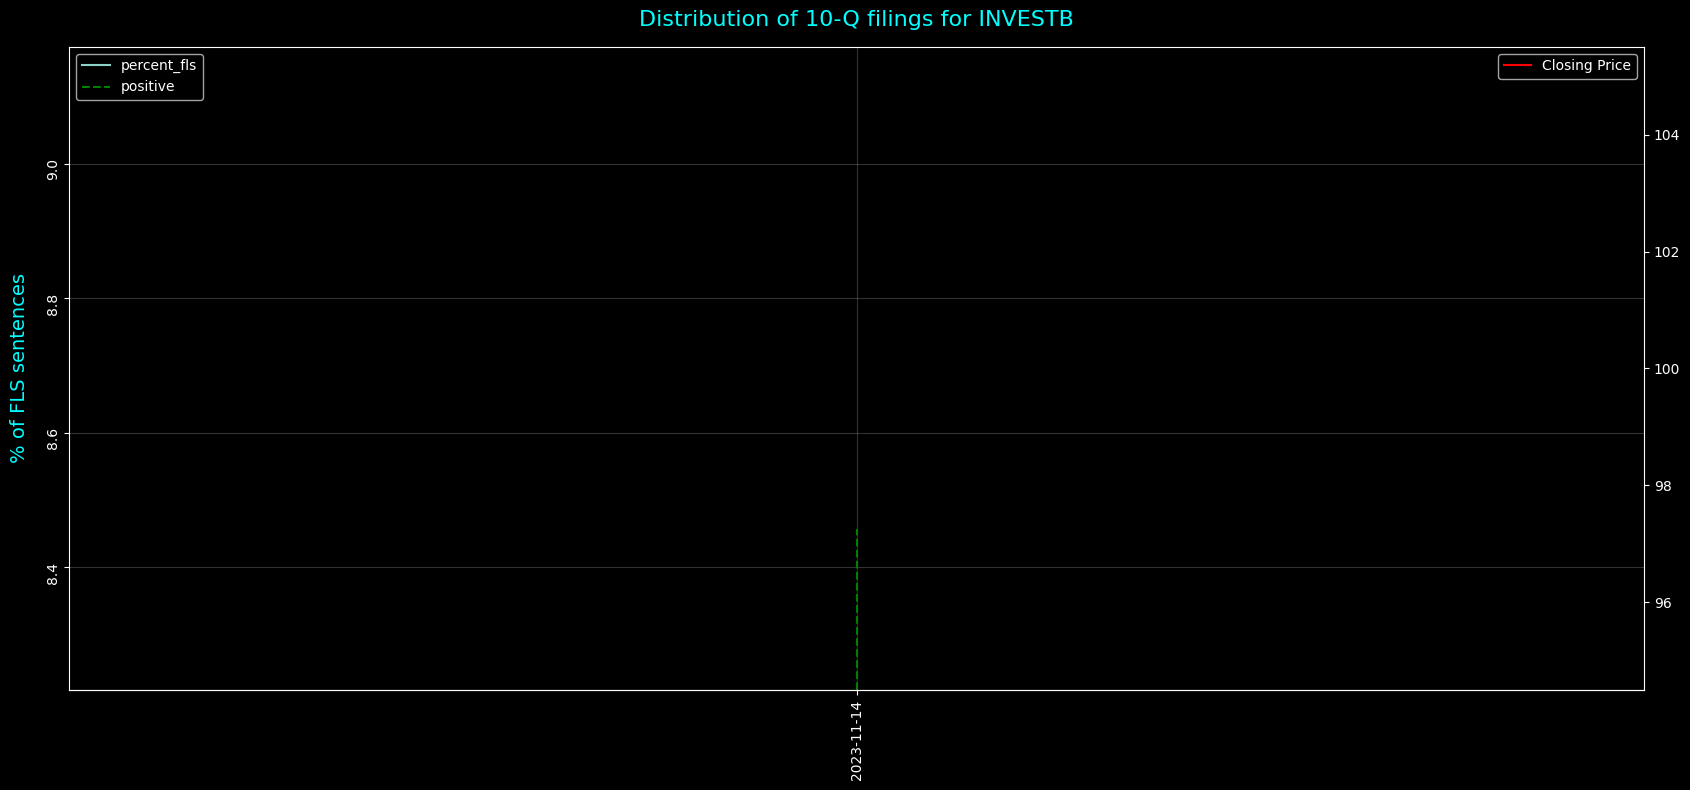

In [50]:
# Visualize the results
plot(results['Date'],
      f"Distribution of 10-Q filings for {company_ticker}",
      '% of FLS sentences',
      results['Stock Price on Date'],
      percent_fls=results['FLS_Percentage'],
      _=sentiment_bars(results['Sentiment']))

The x-axis represents the dates of each of the 10-Q filings report captured.  On the left y-axis, we can see the percentage of sentences within the filings that are forward-looking statements and on the right y-axis we have plotted a simple closing price measure as a general indicator of performance over time.  Finally, we have plotted vertical bars along the x-axis to indicate our sentiment measures for the forward-looking statements.

The important measure I want to focus on is the trend and measure of our forward-looking statements for each filing.  As I discussed in the opening, analysts predictions can be subjective, especially when reading text.  The above FLS percentage measure can be interpreted in a number of ways.  For example, if we have a low percentage of FLS statements, does that imply vague outlook? Does a relatively higher percentage of FLS statements indicate confidence?  How do these measures stack up to the stock performance based on the single closing price value?  As expected, it is likely too ambitious to expect a single factor, such as measuring text from a filings report, to provide sound future predictions. Finally, I included a sentiment score for each filing as a possible way to ingest additional analysis into the picture.  In general, all scores fall into the neutral or positive sphere.  As with price, the interpretation of this measure may not be enough to predict any specific outcome.

## Conclusion

What is the general takeaway from the above analysis?  I would suggest that the FLS measurements may provide some very interesting output that requires in-depth research.  While it is interesting to plot the performance of the stock and the general sentiment scores, neither of these basic measures appear to provide any correlation, especially if I attempt to analyze multiple companies.  However, that does not mean further research may not provide more interesting results.  For example, can we capture the time series of the stock over a 10-day period to measure the immediate effect of the filings release?  Possibly introducing a [vector autoregression](https://en.wikipedia.org/wiki/Vector_autoregression) statistical analysis may be an option that could possible unearth meaningful correlation.